# CARGA DE LIBRERIAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import torch
from torch import nn  # Modelos neuronales y funciones de Loss

from torch import optim # (3er paso BACKPROPAGATION) Optimizadores ---> Gradiente descendiente, Adam, AdaDelta, etc
from torch.utils.data import Dataset, DataLoader

import sys

import plotly.express as px

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Elige el dispositivo. Utilizará GPU si está disponible

sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()

In [2]:
dir = str(root) + '/data/'

In [3]:
data = pd.read_csv( dir + 'merval.csv', header=None).to_numpy()

In [4]:
data = data.flatten()

In [5]:
len(data)

478

In [6]:
fig = px.line(data,
              title="Merval"
)
fig.show()

In [7]:
window_size = 5
i = 0
moving_averages = []
  
while i < len(data) - window_size + 1:
    
    # Store elements from i to i+window_size in list to get the current window
    window = data[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average 
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1
  
print(moving_averages)

[232.6, 236.6, 242.0, 244.4, 244.2, 244.0, 248.4, 251.2, 257.6, 271.2, 279.6, 293.0, 310.6, 324.6, 334.8, 358.8, 388.2, 409.2, 428.4, 436.0, 434.4, 424.0, 419.8, 422.8, 428.8, 436.4, 446.8, 453.6, 454.4, 448.4, 434.2, 417.0, 400.2, 383.8, 380.2, 384.4, 385.2, 384.4, 382.8, 380.8, 376.6, 374.8, 380.2, 387.8, 385.8, 385.2, 385.8, 381.6, 378.4, 383.8, 391.2, 395.2, 397.6, 397.8, 397.4, 397.4, 399.2, 402.4, 410.6, 418.8, 424.8, 429.6, 435.6, 435.4, 431.0, 423.6, 413.4, 403.6, 395.6, 389.4, 386.6, 387.2, 382.4, 378.0, 381.4, 388.0, 388.2, 393.4, 401.4, 402.4, 399.8, 402.0, 404.2, 400.6, 397.0, 392.8, 389.6, 383.8, 379.4, 376.4, 373.4, 369.6, 366.0, 361.6, 353.0, 343.2, 338.4, 335.8, 333.0, 330.6, 328.0, 319.2, 309.8, 300.8, 296.2, 289.4, 287.0, 283.8, 281.0, 275.6, 278.2, 281.4, 290.4, 298.2, 308.2, 318.6, 325.4, 327.8, 335.4, 346.0, 350.2, 357.4, 368.4, 374.8, 381.0, 385.8, 386.2, 382.8, 378.6, 373.6, 371.6, 373.4, 375.0, 375.4, 372.6, 370.4, 366.4, 361.8, 360.2, 359.4, 358.4, 357.6, 357.8

In [8]:
len(moving_averages)

474

In [9]:
a = np.zeros(4)
moving_averages = np.concatenate((a, moving_averages), axis=None)

In [10]:
len(moving_averages)

478

In [11]:
variacion_MA5 = np.round(np.subtract(data,moving_averages), 1)

In [12]:
variacion_MA5[0:4] = 0
variacion_MA5[0:4]

array([0., 0., 0., 0.])

In [13]:
data_new = np.concatenate(
    (
        data.reshape(-1,1),
        moving_averages.reshape(-1,1),
        variacion_MA5.reshape(-1,1)
    ),
    axis=1 
)

In [14]:
data_new

array([[215. ,   0. ,   0. ],
       [212. ,   0. ,   0. ],
       [229. ,   0. ,   0. ],
       ...,
       [994. , 977.2,  16.8],
       [997. , 987.6,   9.4],
       [999. , 993.2,   5.8]])

In [15]:
# descarto las primeras 4 observaciones
data_new = data_new[5:478, :]
data_new

array([[235. , 236.6,  -1.6],
       [239. , 242. ,  -3. ],
       [241. , 244.4,  -3.4],
       ...,
       [994. , 977.2,  16.8],
       [997. , 987.6,   9.4],
       [999. , 993.2,   5.8]])

In [16]:
len(data_new)

473

In [17]:
split = np.round( len(data_new) * 0.9).astype(int)

merval_train = data_new[0:split, :]
merval_test = data_new[split:, :]

len(merval_train), len(merval_test)

(426, 47)

In [18]:
np.savetxt(dir + 'merval_train.csv', merval_train, fmt='%1.4f,%1.4f,%i', delimiter=',')
np.savetxt(dir + 'merval_test.csv', merval_train, fmt='%1.4f,%1.4f,%i', delimiter=',')

In [19]:
fig = px.line(data_new[:,:-1],
              title="Merval"
)
fig.show()

# RBF NN

Sure, let's break down what's happening in this `radial_basis` function:

1. `C = self.centers.view(self.num_centers, -1)`: This reshapes the centers of the radial basis functions (RBFs), stored in `self.centers`, into a 2D tensor with shape `(num_centers, -1)`. The `-1` is a placeholder that means "infer the size of this dimension from the data". In this case, it corresponds to the dimension of the input space (i.e., the number of features in the input data).

2. `x = x.unsqueeze(1).expand(-1, self.num_centers, -1)`: This line is doing two things. First, `unsqueeze(1)` adds an extra dimension to the input data tensor `x`, changing its shape from `(batch_size, input_dim)` to `(batch_size, 1, input_dim)`. This extra dimension is needed so that `x` and `C` have the same number of dimensions and can be subtracted from each other in the next line. Then, `expand(-1, self.num_centers, -1)` replicates the input data along the new dimension to match the number of centers. The `-1`s here are placeholders that mean "keep the size of this dimension the same as in the original data".

3. `return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))`: This is the computation of the RBF. The expression `(x - C) ** 2` calculates the squared Euclidean distance between each data point and each center. `torch.sum(..., dim=2)` sums these squared distances over the input dimensions to get the total squared distance for each data point and each center. This result is divided by `2 * self.sigma ** 2`, and the negative of this is passed through the exponential function `torch.exp()` to get the output of the RBF.

So, the output of this function is a tensor `H` with shape `(batch_size, num_centers)`, where `H[i, j]` is the output of the `j`-th RBF for the `i`-th data point. This tensor `H` is then passed through the linear layer in the `forward` method to get the final output of the network.

In [20]:
class RBFNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_centers, sigma):
        super(RBFNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_centers = num_centers
        
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers, 1) / num_centers)
        self.sigma = sigma
        
        self.fc = nn.Linear(num_centers, output_dim)
    
    def radial_basis(self, x):
        C = self.centers.view(self.num_centers, -1)
        x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        H = self.radial_basis(x)
        out = self.fc(H)
        return out

In [21]:
class DATASET(Dataset):  # <----------------
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=0) # Levanta los datos en formato numpy
        
        #------------------------------------
        # TRANSFORMO A DATOS DE NUMPY
        data = data.to_numpy()
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,1:2].astype(np.float32)
        self.y = data[:,0].astype(np.longlong)  
        
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

In [22]:
BATCH_SIZE=32
filename_train = dir + 'merval_train.csv'
filename_test = dir + 'merval_test.csv'

trn = DATASET(filename_train)
tst = DATASET(filename_test)

train_loader = DataLoader(trn, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(tst, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
input_dim = 2 
hidden_dim = 200
output_dim = 1
num_centers = 200
sigma = 1
model = RBFNet(input_dim, hidden_dim, output_dim, num_centers, sigma)

# loss function and an optimizer
criterion = nn.MSELoss() 
#criterion = nn.L1Loss() 
optimizer = optim.Adam(model.parameters(), lr=0.015)

# epochs
epochs = 5000

# Evaluation metric
from torchmetrics import MeanAbsoluteError
mae = MeanAbsoluteError()

In [24]:
train_losses = []
test_losses = []
test_maes = []  
predictions = []
actuals = []

# Training loop
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train() 
    for inputs, labels in train_loader:
        labels = labels.float()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        loss.backward() 
        optimizer.step() 
        train_loss = loss.item() * inputs.size(0) 

    model.eval()
    with torch.no_grad():
        total_mae = 0.0
        for inputs, labels in test_loader:
            labels = labels.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            test_loss = loss.item() * inputs.size(0)
            # calculate MAE
            total_mae += mae(outputs, labels.view(-1, 1))
            # Save predictions and actual labels in the last epoch
            if epoch == epochs - 1:
                predictions.extend(outputs.detach().numpy())
                actuals.extend(labels.view(-1, 1).detach().numpy())
    
    
    # Convert lists to numpy arrays
    if epoch == epochs - 1:
        predictions = np.array(predictions)
        actuals = np.array(actuals)

    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    average_mae = total_mae / len(test_loader)

    # append losses and MAE
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_maes.append(average_mae)

    if (epoch % 500) == 0:
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f} \tTest MAE: {average_mae:.6f}')

Epoch: 1 	Training Loss: 5661.419559 	Test Loss: 4109.104853 	Test MAE: 501.873627
Epoch: 501 	Training Loss: 2618.182886 	Test Loss: 2479.411820 	Test MAE: 399.613525
Epoch: 1001 	Training Loss: 3163.411654 	Test Loss: 1308.865037 	Test MAE: 299.068756
Epoch: 1501 	Training Loss: 1641.886544 	Test Loss: 575.847794 	Test MAE: 202.672363
Epoch: 2001 	Training Loss: 414.264292 	Test Loss: 260.886404 	Test MAE: 133.102768
Epoch: 2501 	Training Loss: 302.671096 	Test Loss: 292.997709 	Test MAE: 126.265427
Epoch: 3001 	Training Loss: 615.287482 	Test Loss: 367.383764 	Test MAE: 128.346268
Epoch: 3501 	Training Loss: 346.133631 	Test Loss: 370.823658 	Test MAE: 128.462082
Epoch: 4001 	Training Loss: 321.926216 	Test Loss: 371.027606 	Test MAE: 128.469147
Epoch: 4501 	Training Loss: 427.285009 	Test Loss: 371.868502 	Test MAE: 128.498337


In [25]:
first_observation = merval_test[0, 1:2]  # Get the first observation and label
first_label = merval_test[0, 0]
# Reshape the observation to add an extra dimension for the batch size
# And convert to tensor if not already
first_observation = torch.tensor(first_observation, dtype=torch.float).unsqueeze(0)

model.eval()  # Put the model in evaluation mode
with torch.no_grad():  # Disable gradient calculation
    prediction = model(first_observation)  # Pass the observation through the model

print("Prediction: ", prediction.item())  # print the prediction
print("Actual value: ", first_label)  # print the actual label

Prediction:  506.01806640625
Actual value:  812.0


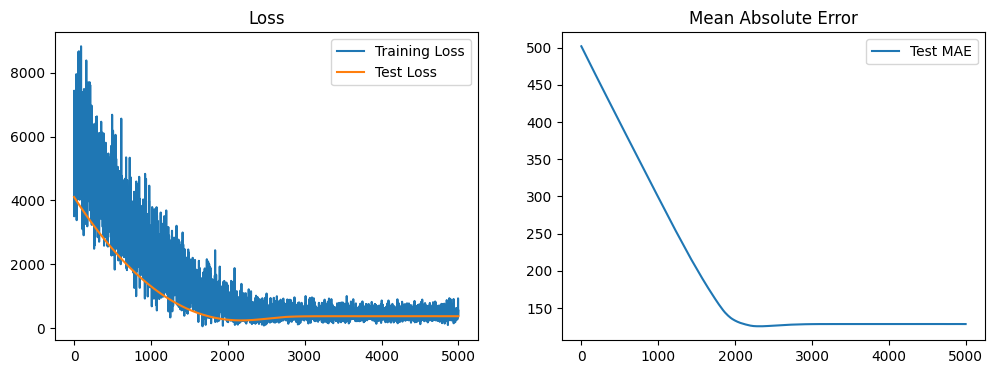

In [26]:
# plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_maes, label='Test MAE')
plt.legend()
plt.title('Mean Absolute Error')

plt.show()


In [ ]:
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Prediccion')
plt.grid(True)
plt.show()